In [24]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import concurrent.futures
from tensorflow.keras.models import Model
from tensorflow.keras.layers import UpSampling2D,Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input, Dropout
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Load the Dataset

In [2]:
DATA_PATH = "/kaggle/input/face-crop/face_crop"
TRUTH_PATH = "/kaggle/input/face-crop/face_crop_segmentation"

In [3]:
image_files = sorted(os.listdir(DATA_PATH))
mask_files = sorted(os.listdir(TRUTH_PATH))
valid_files = list(set(image_files) & set(mask_files))
valid_files.sort()

def process_image_mask(file):
    img_path = os.path.join(DATA_PATH, file)
    mask_path = os.path.join(TRUTH_PATH, file)

    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if img is not None and mask is not None:
        img = cv2.resize(img, (64, 64)) / 255.0
        mask = cv2.resize(mask, (64, 64), interpolation=cv2.INTER_NEAREST)
        mask = (mask > 127).astype(np.uint8)
        return img, mask
    return None

def load_dataset():
    X, Y = [], []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(process_image_mask, valid_files), total=len(valid_files), desc="Loading images & masks"))

    results = [res for res in results if res is not None]
    X, Y = zip(*results)
    return np.array(X), np.array(Y)

X_masked, Y_true = load_dataset()

print(f"Total images loaded: {len(X_masked)}")
print(f"Total masks loaded: {len(Y_true)}")

assert len(X_masked) == len(Y_true), "Mismatch in image-mask pairs!"

Loading images & masks: 100%|██████████| 9382/9382 [00:15<00:00, 601.18it/s]


Total images loaded: 9382
Total masks loaded: 9382


# Using Handcrafted features
1. Otsu
2. Canny Edge Detection
3. Morphological Closing
4. K-means segmentation

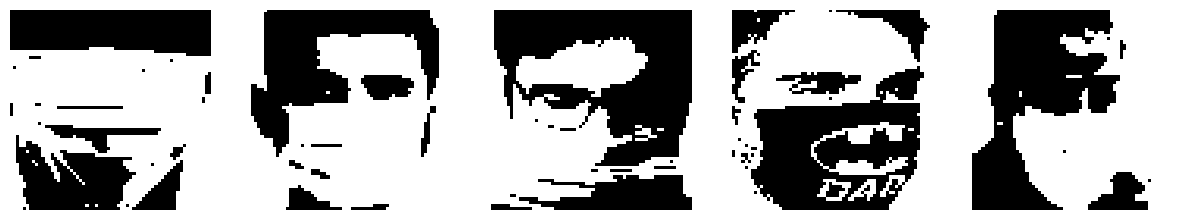

In [4]:
def apply_otsu_threshold(img):
    img = (img * 255).astype(np.uint8)

    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    _, binary_img = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
    return binary_img



fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    thresholded_img = apply_otsu_threshold(X_masked[i])
    axes[i].imshow(thresholded_img, cmap='gray')
    axes[i].axis("off")
plt.show()

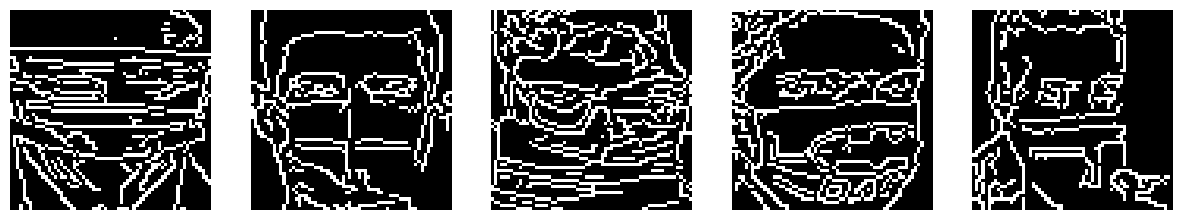

In [5]:
def apply_canny_edge(img):
    img = (img * 255).astype(np.uint8)

    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    edges = cv2.Canny(img, 50, 150)
    return edges

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    edge_img = apply_canny_edge(X_masked[i])
    axes[i].imshow(edge_img, cmap='gray')
    axes[i].axis("off")
plt.show()


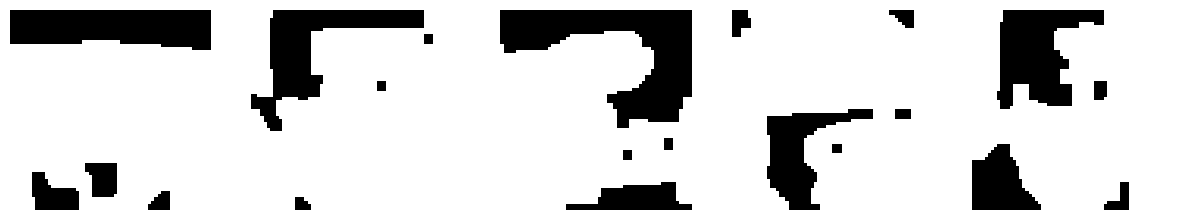

In [6]:
def apply_morphological_closing(img):
    img = (img * 255).astype(np.uint8) if img.max() <= 1 else img  # Convert [0,1] to [0,255]

    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    img = (img > 127).astype(np.uint8) * 255

    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(img, kernel, iterations=2)
    closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel)
    return closed


fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    morph_img = apply_morphological_closing(apply_otsu_threshold(X_masked[i]))
    axes[i].imshow(morph_img, cmap='gray')
    axes[i].axis("off")
plt.show()


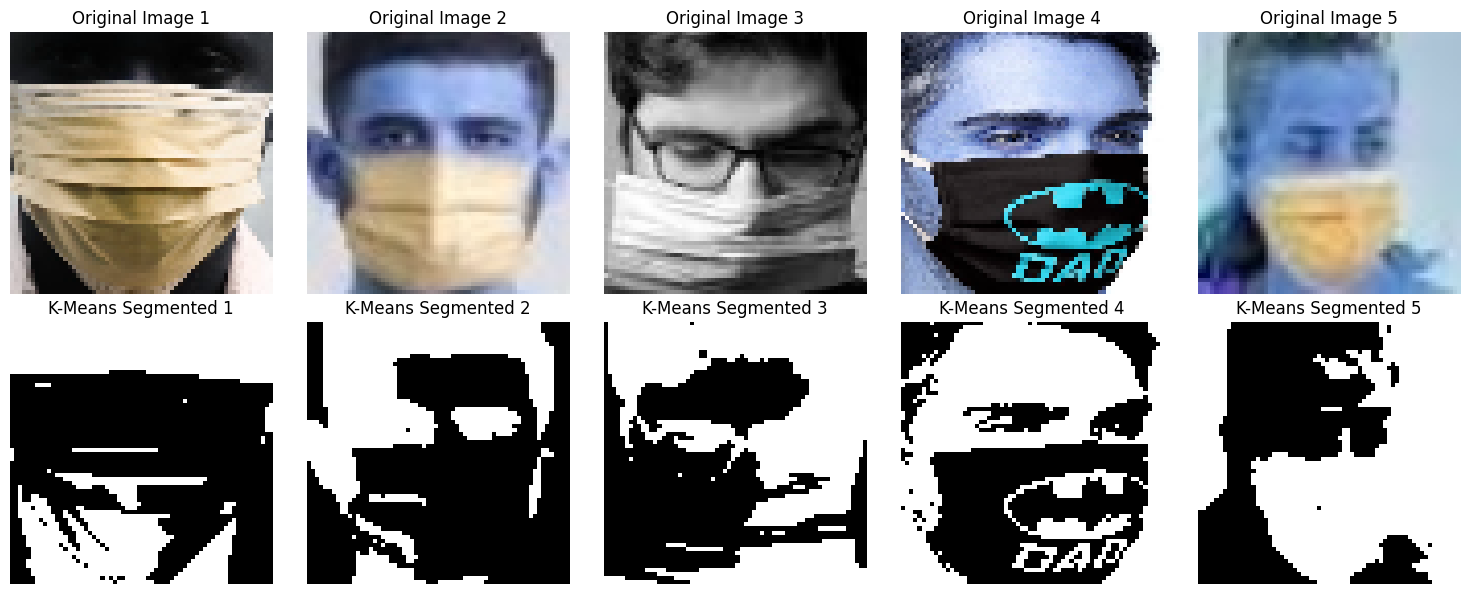

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_kmeans_segmentation(img, K=2):
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pixel_values = img.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    _, labels, centers = cv2.kmeans(pixel_values, K, None,
                                    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2), 
                                    10, cv2.KMEANS_RANDOM_CENTERS)

    segmented_img = labels.reshape(img.shape[:2])
    return (segmented_img * (255 // (K - 1))).astype(np.uint8)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    original_img = X_masked[i]
    kmeans_img = apply_kmeans_segmentation(original_img, K=2)

    axes[0, i].imshow(original_img)
    axes[0, i].set_title(f"Original Image {i+1}")
    axes[0, i].axis("off")

    axes[1, i].imshow(kmeans_img, cmap="gray")
    axes[1, i].set_title(f"K-Means Segmented {i+1}")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


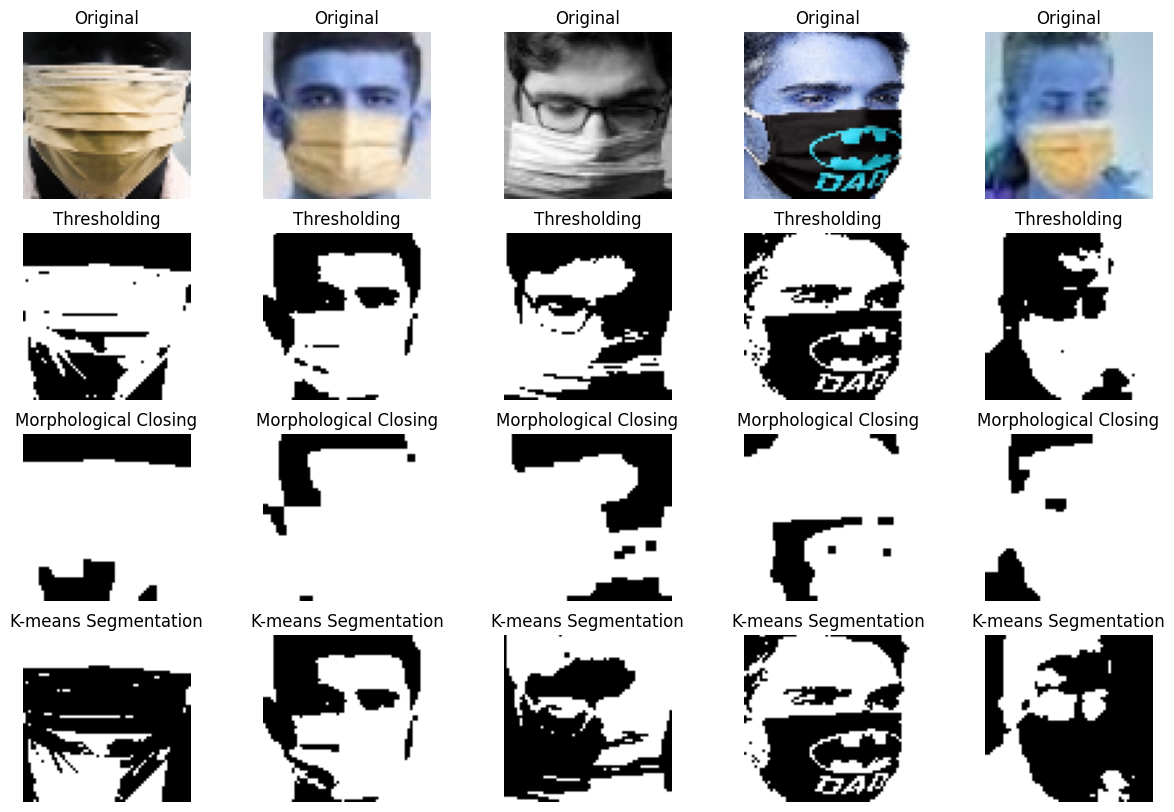

In [8]:
fig, axes = plt.subplots(4, 5, figsize=(15, 10))

for i in range(5):
    axes[0, i].imshow(X_masked[i], cmap='gray')
    axes[0, i].set_title("Original")
    axes[0, i].axis("off")

    axes[1, i].imshow(apply_otsu_threshold(X_masked[i]), cmap='gray')
    axes[1, i].set_title("Thresholding")
    axes[1, i].axis("off")

    axes[2, i].imshow(apply_canny_edge(X_masked[i]), cmap='gray')
    axes[2, i].set_title("Canny Edges")
    axes[2, i].axis("off")

    axes[2, i].imshow(apply_morphological_closing(X_masked[i]), cmap='gray')
    axes[2, i].set_title("Morphological Closing")
    axes[2, i].axis("off")

    axes[3, i].imshow(apply_kmeans_segmentation(X_masked[i]), cmap='gray')
    axes[3, i].set_title("K-means Segmentation")
    axes[3, i].axis("off")

plt.show()


# Compute IoU and Dice Scores

In [9]:
from skimage.metrics import adapted_rand_error
from scipy.spatial.distance import dice

def compute_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    return intersection / union if union != 0 else 0

def compute_dice(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    return 2 * intersection / (pred_mask.sum() + gt_mask.sum()) if (pred_mask.sum() + gt_mask.sum()) != 0 else 0


In [10]:
def binarize_mask(mask):
    return (mask > 127).astype(np.uint8)

iou_otsu, dice_otsu = [], []
iou_canny, dice_canny = [], []
iou_morph, dice_morph = [], []
iou_kmeans,dice_kmeans = [], []
for i in range(len(Y_true)):
    gt_mask = Y_true[i]
    img = X_masked[i]

    pred_otsu = apply_otsu_threshold(img)
    pred_otsu = binarize_mask(pred_otsu)
    iou_otsu.append(compute_iou(pred_otsu, gt_mask))
    dice_otsu.append(compute_dice(pred_otsu, gt_mask))

    pred_canny = apply_canny_edge(img)
    pred_canny = binarize_mask(pred_canny)
    iou_canny.append(compute_iou(pred_canny, gt_mask))
    dice_canny.append(compute_dice(pred_canny, gt_mask))

    pred_morph = apply_morphological_closing(pred_otsu)
    pred_morph = binarize_mask(pred_morph)
    iou_morph.append(compute_iou(pred_morph, gt_mask))
    dice_morph.append(compute_dice(pred_morph, gt_mask))

    pred_kmeans = apply_kmeans_segmentation(img)
    pred_kmeans = binarize_mask(pred_kmeans)
    iou_kmeans.append(compute_iou(pred_kmeans, gt_mask))
    dice_kmeans.append(compute_dice(pred_kmeans, gt_mask))

print(f"Otsu's Thresholding -> IoU: {np.mean(iou_otsu):.4f}, Dice Score: {np.mean(dice_otsu):.4f}")
print(f"Canny Edge Detection -> IoU: {np.mean(iou_canny):.4f}, Dice Score: {np.mean(dice_canny):.4f}")
print(f"Morphological Closing -> IoU: {np.mean(iou_morph):.4f}, Dice Score: {np.mean(dice_morph):.4f}")
print(f"K-means Segmentation -> IoU: {np.mean(iou_kmeans):.4f}, Dice Score: {np.mean(dice_kmeans):.4f}")

Otsu's Thresholding -> IoU: 0.2910, Dice Score: 0.4070
Canny Edge Detection -> IoU: 0.1566, Dice Score: 0.2644
Morphological Closing -> IoU: 0.3174, Dice Score: 0.4607
K-means Segmentation -> IoU: 0.2614, Dice Score: 0.3671


# Build U-Net

In [ ]:
strategy = tf.distribute.MirroredStrategy()

print(f"Using {strategy.num_replicas_in_sync} GPUs")

with strategy.scope():
    def build_light_unet(input_shape=(64, 64, 3)):
        inputs = Input(input_shape)

        conv1 = Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
        conv1 = Conv2D(32, (3,3), activation="relu", padding="same")(conv1)
        pool1 = MaxPooling2D((2,2))(conv1)

        conv2 = Conv2D(64, (3,3), activation="relu", padding="same")(pool1)
        conv2 = Conv2D(64, (3,3), activation="relu", padding="same")(conv2)
        pool2 = MaxPooling2D((2,2))(conv2)

        conv3 = Conv2D(128, (3,3), activation="relu", padding="same")(pool2)
        conv3 = Conv2D(128, (3,3), activation="relu", padding="same")(conv3)
        pool3 = MaxPooling2D((2,2))(conv3)

        conv4 = Conv2D(256, (3,3), activation="relu", padding="same")(pool3)
        conv4 = Conv2D(256, (3,3), activation="relu", padding="same")(conv4)

        up1 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(conv4)
        up1 = concatenate([up1, conv3])
        conv5 = Conv2D(128, (3,3), activation="relu", padding="same")(up1)
        conv5 = Conv2D(128, (3,3), activation="relu", padding="same")(conv5)

        up2 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(conv5)
        up2 = concatenate([up2, conv2])
        conv6 = Conv2D(64, (3,3), activation="relu", padding="same")(up2)
        conv6 = Conv2D(64, (3,3), activation="relu", padding="same")(conv6)

        up3 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(conv6)
        up3 = concatenate([up3, conv1])
        conv7 = Conv2D(32, (3,3), activation="relu", padding="same")(up3)
        conv7 = Conv2D(32, (3,3), activation="relu", padding="same")(conv7)

        outputs = Conv2D(1, (1,1), activation="sigmoid")(conv7)

        model = Model(inputs, outputs)
        model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
        return model

    unet_model = build_light_unet()

unet_model.summary()


Using 2 GPUs


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 32, 32)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 16, 16, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 8, 8, 128)      │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 8, 8, 256)      │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 8, 8, 256)      │        590,080 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 128)    │        131,200 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16, 16, 256)    │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 128)    │        295,040 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 32, 32, 64)     │         32,832 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)    

 Total params: 1,925,601 (7.35 MB)

 Trainable params: 1,925,601 (7.35 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X_masked, Y_true, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape, Y_train.shape)
print("Testing set shape:", X_test.shape, Y_test.shape)

history = unet_model.fit(X_train, Y_train, epochs=10, batch_size=16, validation_data=(X_test, Y_test))

Training set shape: (7505, 64, 64, 3) (7505, 64, 64)
Testing set shape: (1877, 64, 64, 3) (1877, 64, 64)
Epoch 1/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.8256 - loss: nan - val_accuracy: 0.9385 - val_loss: 0.1527
Epoch 2/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9443 - loss: nan - val_accuracy: 0.9593 - val_loss: 0.1025
Epoch 3/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9611 - loss: nan - val_accuracy: 0.9616 - val_loss: 0.0953
Epoch 4/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9651 - loss: nan - val_accuracy: 0.9674 - val_loss: 0.0839
Epoch 5/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9695 - loss: nan - val_accuracy: 0.9706 - val_loss: 0.0743
Epoch 6/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9719 - loss: nan - val_accuracy: 0.9709 - val_loss: 0.0743
Epoch 7/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9738 - loss: nan - val_accuracy: 0.9664 - val_loss: 0.0841
Epoch 

In [13]:
test_loss, test_acc = unet_model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9728 - loss: 0.0738
Test Accuracy: 97.39%


# Visualization of U-net Output

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


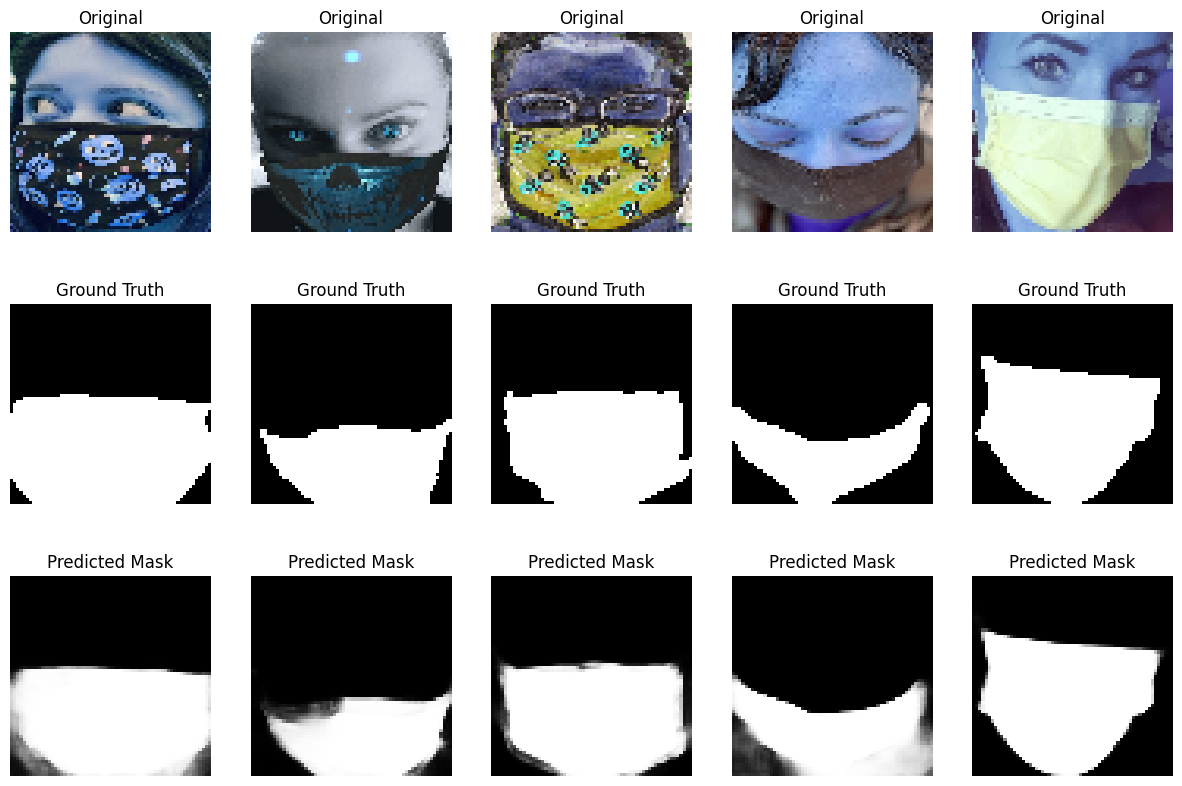

In [33]:
preds = unet_model.predict(X_test[:5])

fig, axes = plt.subplots(3, 5, figsize=(15, 10))

for i in range(5):
    axes[0, i].imshow(X_test[i])
    axes[0, i].set_title("Original")
    axes[0, i].axis("off")

    axes[1, i].imshow(Y_test[i].squeeze(), cmap="gray")
    axes[1, i].set_title("Ground Truth")
    axes[1, i].axis("off")

    axes[2, i].imshow(preds[i].squeeze(), cmap="gray")
    axes[2, i].set_title("Predicted Mask")
    axes[2, i].axis("off")

plt.show()

In [34]:
predictions = unet_model.predict(X_test)

iou_scores, dice_scores = [], []

for i in range(len(Y_test)):
    iou = compute_iou(predictions[i], Y_test[i])
    dice = compute_dice(predictions[i], Y_test[i])
    iou_scores.append(iou)
    dice_scores.append(dice)

print(f"U-Net IoU Score: {np.mean(iou_scores):.4f}")
print(f"U-Net Dice Score: {np.mean(dice_scores):.4f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
U-Net IoU Score: 0.8532
U-Net Dice Score: 0.9245
